Домашнее задание
<br>Практический проект по предсказанию рейтинга фильма.
<br>Цель: В этом задании вам предстоит поработать с методом tf-idf чтобы извлечь признаки из текста для построения моделей.
1. Скачайте данные по отзывам с сайта IMDB (https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews), в которых для каждого отзыва поставлена семантическая оценка - "позитивный" или "негативный". 

2. Разбейте данные на train/test, отложив 30% наблюдений для тестирования (датасет достаточно большой и выборка сбалансированная, так что можно не беспокоиться о стратификации)

3. Примените tf-idf преобразование. Используйте как отдельные токены, так и биграммы, отсейте английские стоп-слова, а также слова, которые встречаются реже, чем в двух отзывах, или чаще, чем в 50% отзывов (параметры min/max_df), не забудьте убрать l2 регуляризацию, которая по умолчанию включена

4. Постройте логистическую регрессию с настройкой параметра регуляризации, оцените качество при помощи метрик для бинарной классификации

5. Визуализируйте получившиеся коэффициенты регрессии (возьмите топ-50 слов). Какие слова наиболее характерны для отрицательных отзывов? Какие для положительных?
<br>Критерии оценки: Предобработка текста в tf-idf - 6 баллов
<br>Логит регрессия с оценкой качества - 2 балла
<br>Визуализация коэффициентов - 2 балла

In [42]:
import pandas as pd
import numpy as np
import re
import warnings
warnings.simplefilter("ignore")

from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline

In [60]:
import nltk
from nltk.corpus import stopwords

In [62]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

## 1) Предобработка данных

In [2]:
data = pd.read_csv('IMDB Dataset.csv')

In [32]:
data['sentiment'].unique()

array(['positive', 'negative'], dtype=object)

In [33]:
data['sentiment'] = data['sentiment'].map({'positive':1, 'negative':0})
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


Для текстов на английском языке хорошо работает стемминг, который к тому же еще и быстрыее, чем лемматизация. Без стемминга результат roc_auc оказался на уровне 0.5, что соответствует случайному подбору значения тональности.

In [63]:
stop = stopwords.words('english')
stemmer = nltk.stem.snowball.EnglishStemmer('english')

def data_Stemmer(text):
    return ' '.join([stemmer.stem(word) for word in text.split(' ') if word not in stop])

In [64]:
data.review = data.review.apply(lambda x: x.lower().replace('unknown', ''))
data.review = data.review.apply(lambda x: data_Stemmer(x))
data.head()

,review,sentiment
0,one review mention watch 1 oz episod hooked. r...,1
1,wonder littl production. <br /><br />the film ...,1
2,thought wonder way spend time hot summer weeke...,1
3,basic there famili littl boy (jake) think ther...,0
4,"petter mattei ""love time money"" visual stun fi...",1


In [65]:
train = data.sample(int(data.shape[0] * 0.7)).reset_index(drop=True)
test = data[~data.index.isin(train.index)].reset_index(drop=True)
print(data.shape, train.shape, test.shape)

(50000, 2) (35000, 2) (15000, 2)


In [66]:
# tf-idf преобразование
from sklearn.feature_extraction.text import TfidfVectorizer

min_df = np.round(2/train.shape[0], 5)

tf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), min_df=min_df, max_df=0.5, norm=None)
features = tf_vectorizer.fit_transform(train['review']).todense()

In [67]:
# здесь можно наблюдать, как отработал стемминг
tf_vectorizer.vocabulary_

{'featur': 70684,
 'fine': 75849,
 'story': 191238,
 'line': 114739,
 'color': 39333,
 'charact': 33804,
 'steadi': 189387,
 'pace': 144212,
 'incorpor': 99055,
 'plot': 151744,
 'devic': 51864,
 'reap': 162605,
 'wild': 219758,
 'wind': 220067,
 'sinc': 181676,
 'cecil': 32718,
 'direct': 53250,
 'son': 185294,
 'law': 109542,
 'quinn': 159112,
 'preparations': 155163,
 'hard': 90048,
 'coincidence': 39083,
 'work': 221776,
 'cases': 31781,
 'report': 165498,
 'unusu': 210646,
 'set': 177982,
 'tell': 197758,
 'viewer': 213269,
 'island': 101702,
 'rule': 169592,
 'jean': 102560,
 'lafitt': 108294,
 'built': 29089,
 'war': 215586,
 'alway': 7871,
 'refrain': 163804,
 'bother': 23544,
 'unit': 210102,
 'state': 189123,
 'vessels': 212674,
 'general': 81468,
 'andrew': 9101,
 'jackson': 102076,
 'charg': 35205,
 'defend': 50002,
 'nearbi': 137110,
 'new': 137779,
 'orlean': 143381,
 '12': 366,
 '000': 5,
 'men': 126833,
 '60': 1405,
 'british': 28040,
 'imperi': 98263,
 'redcoat': 16358

In [68]:
Xtr_tfidf = tf_vectorizer.fit_transform(train['review'])
Xval_tfidf = tf_vectorizer.transform(test['review'])

y_tr = train['sentiment']
y_val = test['sentiment']

Xtr_tfidf.shape, Xval_tfidf.shape

((35000, 226019), (15000, 226019))

## 2) Подбор параметров логистической регрессии

In [72]:
logit_cv = LogisticRegressionCV(Cs=10, n_jobs=-1)
logit_cv.fit(Xtr_tfidf, y_tr)
pred = logit_cv.predict(Xval_tfidf)

print(accuracy_score(y_val, pred))
print(classification_report(y_val, pred))
print(roc_auc_score(y_val, pred))

0.9704
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      7490
           1       0.97      0.97      0.97      7510

    accuracy                           0.97     15000
   macro avg       0.97      0.97      0.97     15000
weighted avg       0.97      0.97      0.97     15000

0.9703963918158078


In [73]:
logit_cv2 = LogisticRegressionCV(Cs=10, n_jobs=-1, solver='liblinear', penalty='l1')
logit_cv2.fit(Xtr_tfidf, y_tr)
pred = logit_cv2.predict(Xval_tfidf)

print(accuracy_score(y_val, pred))
print(classification_report(y_val, pred))
print(roc_auc_score(y_val, pred))

0.9287333333333333
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      7490
           1       0.92      0.94      0.93      7510

    accuracy                           0.93     15000
   macro avg       0.93      0.93      0.93     15000
weighted avg       0.93      0.93      0.93     15000

0.9287245843992611


In [74]:
logit_cv3 = LogisticRegressionCV(Cs=100, n_jobs=-1)
logit_cv3.fit(Xtr_tfidf, y_tr)
pred = logit_cv3.predict(Xval_tfidf)

print(accuracy_score(y_val, pred))
print(classification_report(y_val, pred))
print(roc_auc_score(y_val, pred))

0.9706
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      7490
           1       0.97      0.97      0.97      7510

    accuracy                           0.97     15000
   macro avg       0.97      0.97      0.97     15000
weighted avg       0.97      0.97      0.97     15000

0.9705964810604107


l1-регуляризация показала результаты несколько хуже, чем l2. При этом для l2 значение Cs оптимальнее при 100.

## 3) Визуализация результатов

### 3.1) ROC-AUC

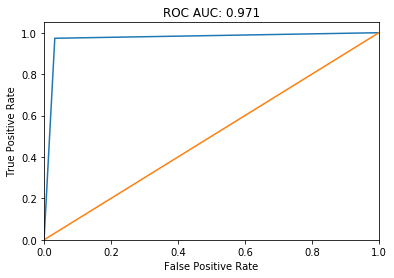

In [75]:
def plot_roc_curve(prob_prediction, y_val):
    fpr, tpr, thresholds = roc_curve(y_val, prob_prediction)
    auc_score = roc_auc_score(y_val, prob_prediction)
    
    plt.plot(fpr, tpr, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC: {:.3f}'.format(auc_score))
    plt.show()
    
plot_roc_curve(pred, y_val)

### 3.2) Визуализация коэффициентов в разрезе тональности отзыва

In [153]:
coef = logit_cv3.coef_
feature_names = tf_vectorizer.get_feature_names()
x = dict(zip(coef[0], feature_names))

top_coef = sorted(x)[-50:]
positive_words = [x[i] for i in top_coef]

bottom_coef = sorted(x)[:50]
negative_words = [x[i] for i in bottom_coef]

Text(0.5, 1.0, 'negative_words')

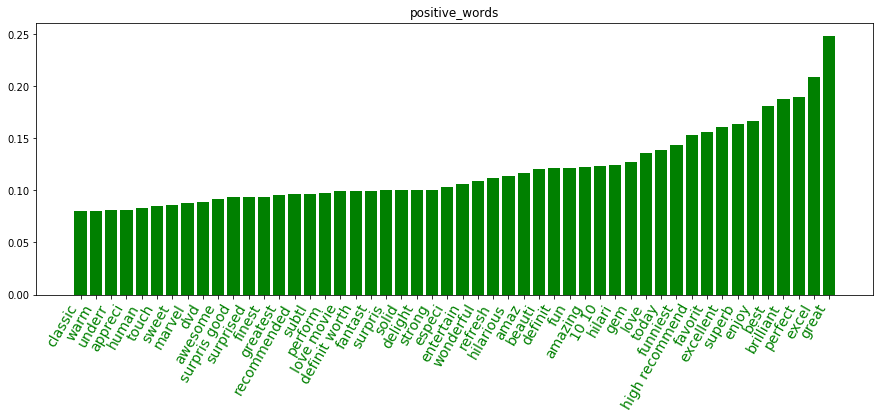

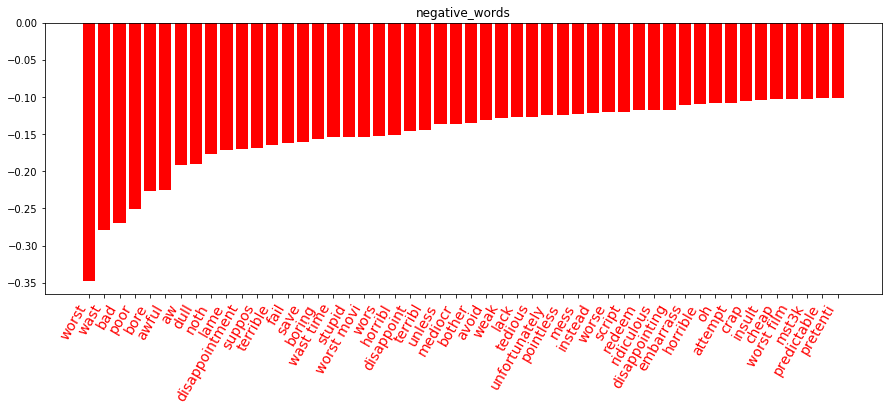

In [161]:
plt.figure(figsize=(15, 5))
plt.bar(positive_words, top_coef, color='g')
plt.xticks(rotation=60, ha="right", fontsize=14, color='g')
plt.title('positive_words')

plt.figure(figsize=(15, 5))
plt.bar(negative_words, bottom_coef, color='r')
plt.xticks(rotation=60, ha="right", fontsize=14, color='r')
plt.title('negative_words')

Позитивным отзывам действительно соответствуют позтивно-окрашенные слова с положительными коэффициентами (топ-50 от 0,08 до 0,25) модели логистической регрессии. В то время как негативные отзывы имеют негативные слова с коэффициентами (50 самых негативных от -0,35 до -0,10).